# Classification of Apoptotic cells

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

In vivo identification of apoptotic and extracellular vesicle-bound live cells using image-based deep learning https://doi.org/10.1080/20013078.2020.1792683

We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

In [1]:
!pip -q install /pstore/home/shetabs1/code/MarrLab/scifAI/

You should consider upgrading via the '/pstore/apps/Python/3.8.3-2020.07/bin/python -m pip install --upgrade pip' command.


here we import a series of needed modules. 

In [2]:
import scifAI
import matplotlib.pyplot as plt
import scifAI.ml.features as features
from scifAI.ml.auto_feature_selection import AutoFeatureSelection
from scifAI.ml.feature_extractor import FeatureExtractor
from scifAI.ml.segmentation import segment_all_channels
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns


here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [3]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(estimator, X, y_true, plot = True ): 
    y_pred = estimator.predict(X)
    print(classification_report(y_true, y_pred))
    print(classification_report_imbalanced(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        plot_confusion_matrix(estimator, X, y_true,cmap = "Greys", xticks_rotation='vertical')
    

now lets calculate the metadata:

In [4]:
%%time

data_path = "/pstore/data/DS4/Apoptotic_cell_detection/"
metadata = scifAI.metadata_generator(data_path)

Metadata prepration starts...
Experiment_1 Donor_1 condition_1


100%|██████████| 15311/15311 [00:01<00:00, 9280.46it/s] 


...metadata prepration ended.
CPU times: user 780 ms, sys: 433 ms, total: 1.21 s
Wall time: 2.04 s


In [5]:
metadata

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,822,labeled,apoptotic
1,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,12187,labeled,non-apoptotic
2,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,2295,labeled,apoptotic
3,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,14306,labeled,non-apoptotic
4,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,2584,labeled,apoptotic
...,...,...,...,...,...,...,...
15306,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,10365,labeled,apoptotic
15307,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,2952,labeled,apoptotic
15308,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,7308,labeled,non-apoptotic
15309,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,3211,labeled,apoptotic


so we have 15311 files with `apoptotic` and 'non-apoptotic' labels. We can now do a feature extraction

In [6]:

feature_union = FeatureUnion([
                                ("MaskBasedFeatures", features.MaskBasedFeatures()), 
                                ("GLCMFeatures", features.GLCMFeatures()),  
                                ("GradientRMS", features.GradientRMS()),  
                                ("BackgroundMean", features.BackgroundMean()), 
                                ("PercentileFeatures", features.PercentileFeatures()), 
                                ("CellShape", features.CellShape()),  
                                ("Collocalization", features.Collocalization()),    
                                ("IntersectionProperties", features.IntersectionProperties()),
                                ("CenterOfCellsDistances", features.CenterOfCellsDistances())
]
)

In [7]:
from scifAI.ml.segmentation import SegmentationGenerator

pipeline = Pipeline([
                     ("features", feature_union)], verbose=3)


In [8]:

feature_extractor = FeatureExtractor(pipeline)

before running the feature extraction, lets look at a random sample (the 0th entry in the metadata dataframe)

In [9]:
image, _ = feature_extractor.get_image_mask(metadata, 0)

[]

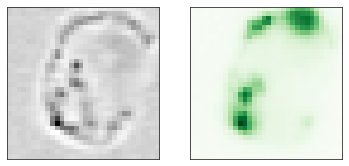

In [10]:
sns.set_style("white")
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 2, 
                       sharex = True, 
                       sharey = True)

ax[0].imshow(image[:,:,0], cmap = "Greys")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(image[:,:,1], cmap = "Greens")
ax[1].set_xticks([])
ax[1].set_yticks([])


In [11]:

list_of_features = feature_extractor.extract_features(metadata)

100%|██████████| 15311/15311 [00:21<00:00, 712.16it/s]


lets create a dataframe with the metadata

In [12]:
df_features = pd.DataFrame(list_of_features)

In [13]:
df_features.head()

,mask_based_area_Ch1,mask_based_bbox_area_Ch1,mask_based_convex_area_Ch1,mask_based_eccentricity_Ch1,mask_based_equivalent_diameter_Ch1,mask_based_euler_number_Ch1,mask_based_extent_Ch1,mask_based_feret_diameter_max_Ch1,mask_based_filled_area_Ch1,mask_based_major_axis_length_Ch1,...,structural_similarity_R2_Ch2_R1_Ch1,hausdorff_distance_R2_Ch2_R1_Ch1,sum_intensity_ratio_Ch1_R1_R2,mean_intensity_ratio_Ch1_R1_R2,max_intensity_ratio_Ch1_R1_R2,sum_intensity_ratio_Ch2_R1_R2,mean_intensity_ratio_Ch2_R1_R2,max_intensity_ratio_Ch2_R1_R2,cell_distance_Ch1_Ch2,weighted_cell_distance_Ch1_Ch2
0,168,242,200,0.889362,14.625466,1,0.694215,22.360680,168,22.463063,...,0.519231,inf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
1,366,486,393,0.788548,21.587165,1,0.753086,29.966648,366,27.948291,...,0.174556,inf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
2,281,361,298,0.333766,18.915082,1,0.778393,21.095023,281,19.548893,...,0.175485,6.403124,0.662920,0.662920,4.548358,0.699263,0.699263,7.606893,4.377484,4.381015
3,331,506,364,0.545581,20.529060,1,0.654150,23.769729,331,22.838270,...,0.131657,inf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
4,177,289,220,0.686567,15.012108,1,0.612457,20.248457,177,18.525576,...,0.415261,12.041595,0.163805,0.163805,7.021026,0.121119,0.121119,5.688325,8.975240,8.954795


after creating the features, we impute empty values with 0. and delete features with no variance. After that, we name the features correctly based on their real name

In [14]:
df_features = df_features.fillna(0.)
df_features = df_features.loc[:, df_features.std() > 0.]

In [15]:
column_dict_rename = dict()

channel_names = {   
         "Ch1": "BF",
         "Ch2": "FL",}

for col in df_features.columns:
    new_col = col
    for ch in channel_names:
        new_col = new_col.replace(ch,channel_names[ch] )
    column_dict_rename[col] = new_col
    
df_features = df_features.rename(columns=column_dict_rename).copy()

let's create a train, validation and test set. We simply use the indexes, as it is easier to use it with sklearn pipelines

In [16]:
from scifAI.dl.utils import train_validation_test_split


train_index, validation_index, test_index = train_validation_test_split(metadata.index, 
                                                                        metadata.loc[:,"label"] + metadata.loc[:,"experiment"] + metadata.loc[:,"donor"],
                                                                        validation_size=0.20, 
                                                                        test_size=0.30)




lets train an XGBoost model on the data. we also use a feature selection before the classifiation to reduce the dimensionality

In [17]:
from sklearn import manifold, datasets
from sklearn import decomposition
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression,RidgeCV,PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR

xgb = Pipeline([
                ('StandardScaler', StandardScaler()), 
                ('AutoFeatureSelection', AutoFeatureSelection( top_k = 50 ,verbose=True)),
                 ('xgb', XGBClassifier(n_jobs = -1, n_estimators = 1000, eval_metric = "logloss") )
], verbose=True)

xgb.fit(df_features.loc[train_index.tolist() + validation_index.tolist(), :],  
       metadata.loc[train_index.tolist() + validation_index.tolist(), "label"] )

[Pipeline] .... (step 1 of 3) Processing StandardScaler, total=   0.0s
Step 1: Find highly correlated features
Step 2: wrapper methods
Calculating mutual information
Calculating SVC
Calculating random forest
Calculating l1 logistic regression
Calculating l2 logistic regression
Calculating xgb
number of similar features among all the methods: 3
From 136 initial features Selected (multicolinear): 87
Step 3: clustering over correlation of features
From 136 initial features Selected (uncorrelated): 50
[Pipeline]  (step 2 of 3) Processing AutoFeatureSelection, total=  20.4s
[Pipeline] ............... (step 3 of 3) Processing xgb, total=   6.4s


Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('AutoFeatureSelection',
                 AutoFeatureSelection(top_k=50, verbose=True)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='logloss', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=1000,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,

               precision    recall  f1-score   support

    apoptotic       0.95      0.94      0.95      2666
non-apoptotic       0.92      0.94      0.93      1928

     accuracy                           0.94      4594
    macro avg       0.93      0.94      0.94      4594
 weighted avg       0.94      0.94      0.94      4594

                     pre       rec       spe        f1       geo       iba       sup

    apoptotic       0.95      0.94      0.94      0.95      0.94      0.88      2666
non-apoptotic       0.92      0.94      0.94      0.93      0.94      0.88      1928

  avg / total       0.94      0.94      0.94      0.94      0.94      0.88      4594

------------------------------------------------------------
matthews correlation coeff: 0.87
Cohen Kappa score: 0.87
Cohen Kappa score: 0.87
Accuracy: 0.94 & balanced Accuracy: 0.94
macro F1 score: 0.94 & micro F1 score: 0.94
macro Precision score: 0.93 & micro Precision score: 0.94
macro Recall score: 0.94 & micro Recall

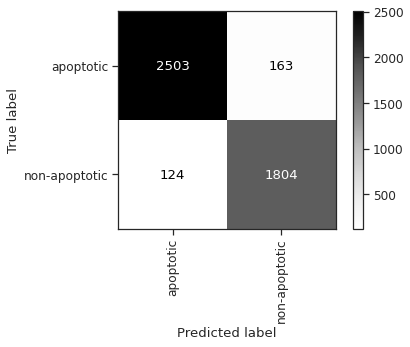

In [18]:
sns.set_style("white")
sns.set(font_scale = 1.1)

sns.set_style("ticks")
classification_complete_report(xgb, 
                               df_features.loc[test_index, :],
                               metadata.loc[test_index, "label"])

the classifier reached macro f1 of 0.95 which is comparable with the main publication. We can also look at the 50 preselected feautres using scifAI

In [19]:
selected_features = xgb.steps[1][1].selected_features
selected_feature_names = df_features.columns[selected_features]
selected_feature_names

Index(['mask_based_equivalent_diameter_BF', 'mask_based_feret_diameter_max_BF',
       'mask_based_max_intensity_BF', 'mask_based_mean_intensity_BF',
       'mask_based_moments_hu-1_BF', 'mask_based_moments_hu-2_BF',
       'mask_based_solidity_BF', 'mask_based_area_FL',
       'mask_based_bbox_area_FL', 'mask_based_eccentricity_FL',
       'mask_based_euler_number_FL', 'mask_based_extent_FL',
       'mask_based_max_intensity_FL', 'mask_based_min_intensity_FL',
       'mask_based_moments_hu-2_FL', 'mask_based_moments_hu-4_FL',
       'mask_based_moments_hu-6_FL', 'mask_based_orientation_FL',
       'mask_based_weighted_moments_hu-0_FL',
       'mask_based_weighted_moments_hu-1_FL',
       'mask_based_weighted_moments_hu-5_FL', 'contrast_BF', 'ASM_BF',
       'contrast_FL', 'dissimilarity_FL', 'homogeneity_FL', 'ASM_FL',
       'gradient_RMS_FL', 'percentile_10_BF', 'percentile_40_BF',
       'percentile_70_BF', 'percentile_80_BF', 'percentile_10_FL',
       'percentile_20_FL', 'percent

Finally, the most important features based on the Gini-index and Permutation importance are:

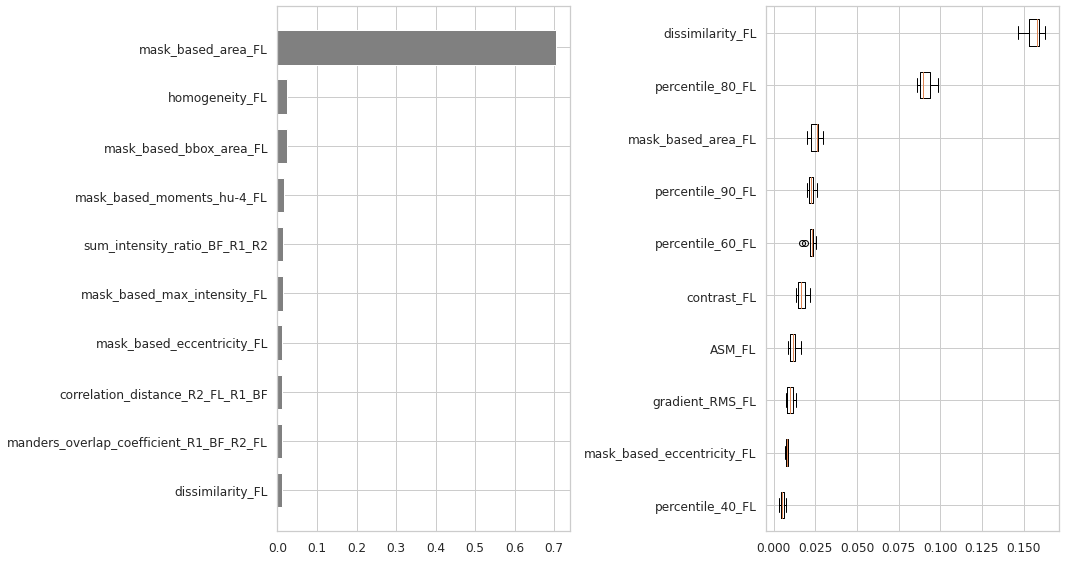

In [20]:
sns.set_style( "whitegrid" )

from sklearn.inspection import permutation_importance

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

tree_importance_sorted_idx = np.argsort(xgb.steps[2][1].feature_importances_)[-10:]

tree_indices = np.arange(0, 10) + 0.5

ax1.barh(tree_indices, 
         xgb.steps[2][1].feature_importances_[tree_importance_sorted_idx], 
         height=0.7, color  = "grey")
ax1.set_yticklabels(df_features.columns[selected_features].values[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)


result = permutation_importance(xgb, 
                                df_features.loc[test_index, :],
                                metadata.loc[test_index, "label"], 
                                n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()[-10:]
ax2.boxplot(result.importances[perm_sorted_idx].T, 
            vert=False,
            labels=df_features.columns.values[perm_sorted_idx])

fig.tight_layout()

As you see, the most important features are from the FL channel which is alignment with the original publication